# Analýza zákazníků

Máme k dispozici seznam zákazníků s jejich osobními informacemi a jejich chováním.

Na trh chceme uvést nový luxusní a drahý výrobek. 

Na které zákazníky máme zaměřit personalizovaný marketing?

# Úkol
- Proveďte základní analýzu dat a jejich vizualizaci
- Proveďte úpravu dat (encoding)
- Vyberte vhodné proměnné, podle kterých půjdou zákazníci segmentovat
- Vytvořte k-mean model s vhodným počtem segmentů
- Vizualizujte model
- Který segment je cílový?

# Načtení dat

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns  
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
import joblib

In [4]:
df=pd.read_csv('../dataset/Mall_Customers.csv')

# Popis  dat
- informace o datech
- náhled na data
- základní statistika
- zobrazení distribuce dat

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
df.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


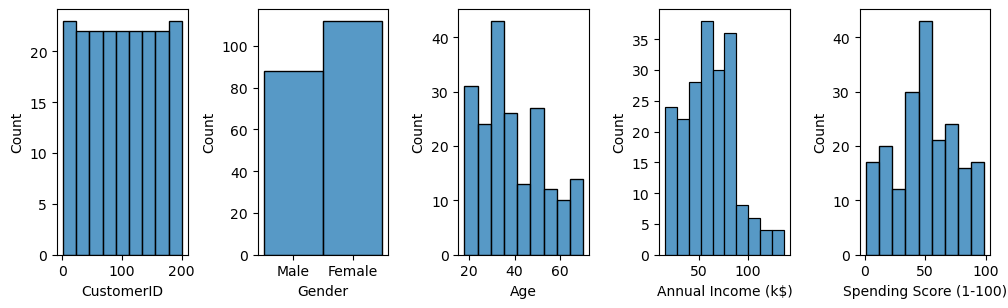

In [8]:
fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(10, 3))
index = 0
axs = axs.flatten()
for k,v in df.items():
    sns.histplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

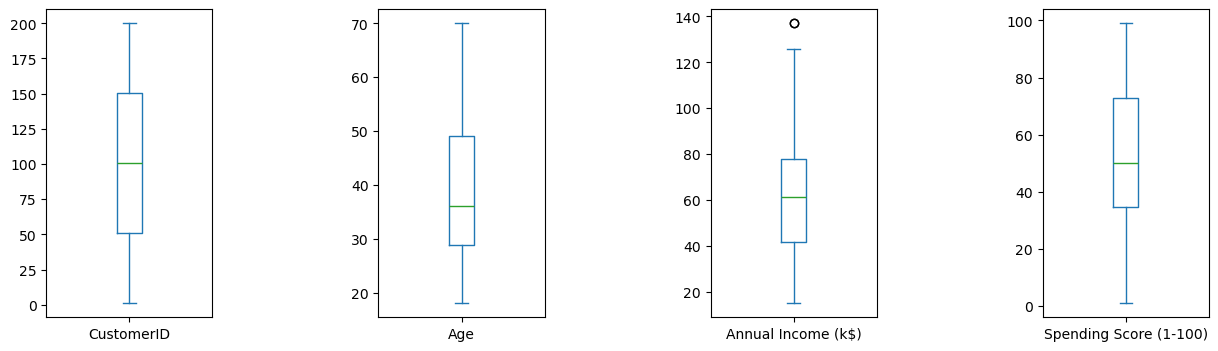

In [9]:
df.plot(
    kind='box', 
    subplots=True, 
    sharey=False, 
    figsize=(15, 4)
)
plt.subplots_adjust(wspace=1) 
plt.show()

# Příprava dat
- ošetření NaN hodnot
- encodování textových sloupců

In [10]:
df.isna().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [11]:
label_encoder = preprocessing.LabelEncoder()
df['gender_enc']=label_encoder.fit_transform(df['Gender'])
joblib.dump(label_encoder, 'classification_encoder.bin', compress=True)

['classification_encoder.bin']

In [12]:
df

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),gender_enc
0,1,Male,19,15,39,1
1,2,Male,21,15,81,1
2,3,Female,20,16,6,0
3,4,Female,23,16,77,0
4,5,Female,31,17,40,0
...,...,...,...,...,...,...
195,196,Female,35,120,79,0
196,197,Female,45,126,28,0
197,198,Male,32,126,74,1
198,199,Male,32,137,18,1


# Výběr proměnných
- zobrazení vztahů mezi proměnnými (pairplot)
- hledáme kombinaci proměnných, které lze opticky ropzdělit do skupin
- vytvoření X pouze s těmito sloupci

In [13]:
df = df[['CustomerID', 'Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'gender_enc']]

/opt/anaconda3/envs/cvika_ver9/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/opt/anaconda3/envs/cvika_ver9/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/opt/anaconda3/envs/cvika_ver9/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/opt/anaconda3/envs/cvika_ver9/lib/python3.9/site-packages/seaborn/axisgrid.py:1513: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  func(x=vector, **plot_kwargs)
/opt/anaconda3/envs/cvika_ver9/lib/python3.9/site-packages/seaborn/axisgrid.py:1615: UserWarning: The palette list has more values (3) than needed (2), whic

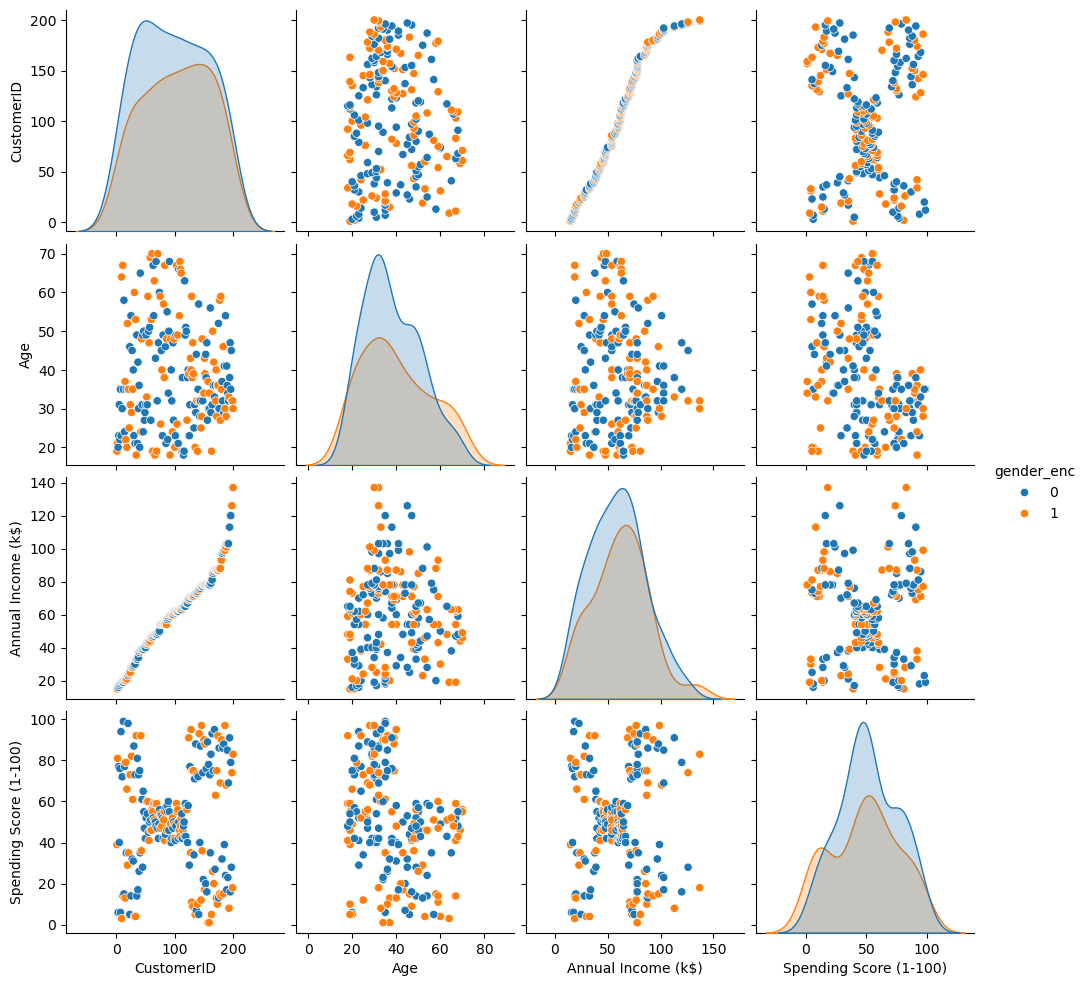

In [14]:
sns.pairplot(df, hue='gender_enc', palette=sns.color_palette(n_colors=3))

<Axes: >

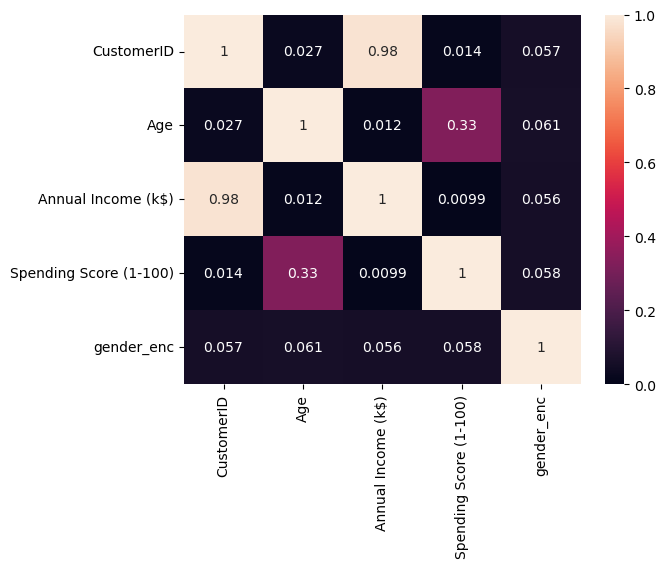

In [15]:
corr=df.corr()
sns.heatmap(corr.abs(), annot=True, vmin=0, vmax=1)

In [39]:
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

# Zjištění parametru modelu k-mean
- vykreslení elbow grafu
- zjištění ideálního počtu clusterů

In [41]:
scaler=StandardScaler()
X_norm=scaler.fit_transform(X)
joblib.dump(scaler, 'classification_std_scaler.bin', compress=True)
scaler=joblib.load('classification_std_scaler.bin')

In [42]:
np.average(X_norm, axis=0)

array([-2.13162821e-16, -1.46549439e-16])

In [43]:
np.min(X_norm, axis=0)

array([-1.73899919, -1.91002079])

In [44]:
np.max(X_norm, axis=0)

array([2.91767117, 1.89449216])

In [45]:
np.std(X_norm, axis=0)

array([1., 1.])

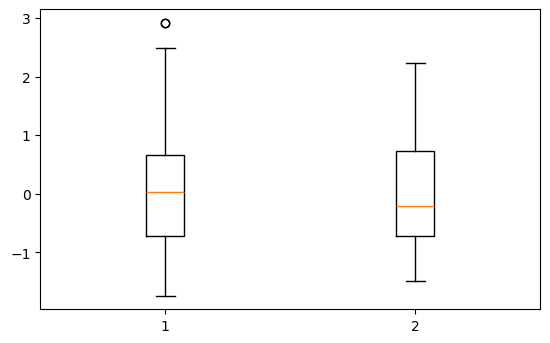

In [24]:
fig = plt.figure(figsize =(5, 3))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(X_norm)
plt.show()

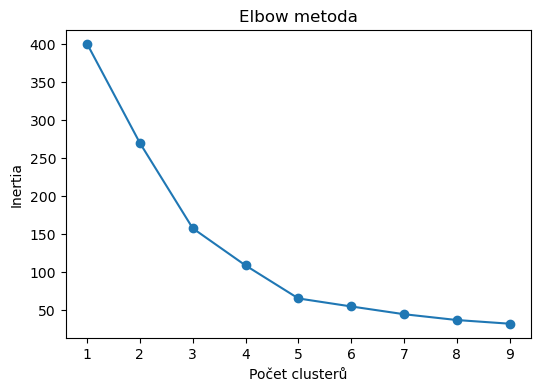

In [46]:
inertia_list = []
for num_clusters in range(1, 10):
    kmeans_model = KMeans(n_clusters=num_clusters, init='k-means++', n_init=10, random_state=42)
    kmeans_model.fit(X_norm)
    inertia_list.append(kmeans_model.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(range(1, 10), inertia_list, marker='o')
plt.xlabel('Počet clusterů')
plt.ylabel('Inertia')
plt.title('Elbow metoda')
plt.show()


# k-mean model pro zjištěný počet clusterů
- natrénování modelu
- predikce dat

In [47]:
optimal_clusters = 5  
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
kmeans.fit(X_norm)

KMeans(n_clusters=5, n_init=10, random_state=42)

In [48]:
df['Cluster'] = kmeans.predict(X_norm)

# Vizualizace modelu
- vykreslení obarvených skupin grafů

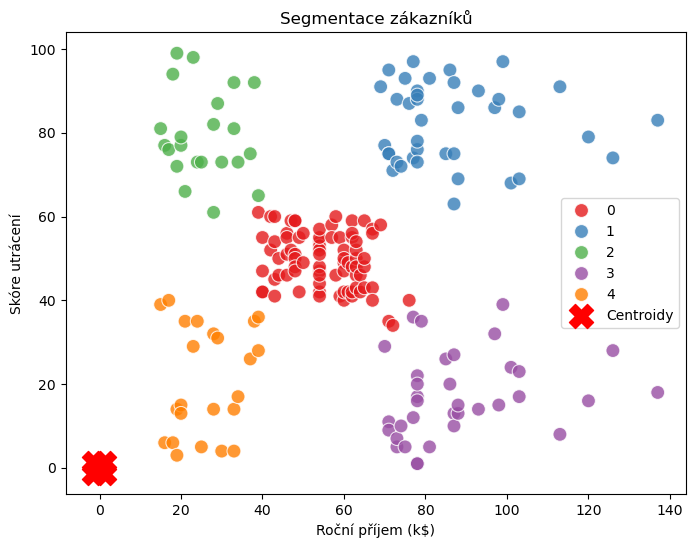

In [49]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=df['Cluster'], palette='Set1', s=100, alpha=0.8)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red', marker='X', label='Centroidy')
plt.xlabel('Roční příjem (k$)')
plt.ylabel('Skóre utrácení')
plt.title('Segmentace zákazníků')
plt.legend()
plt.show()

## Výklad modelu
- Popište jednotlivé skupiny
- Na jaké zákazníky se zaměřit?

### - 0 - Červená skupina
- Zákazníci s průměrným ročním příjmem a průměrným utrácením
- Nemají extrémní chování

### - 1 - Modrá skupina
- Zákazníci s vysokým ročním příjmem a vysokým skórem utrácení
- Zákazníci ideální pro luxusní produkty

### - 2 - Zelená skupina
- Zákazníci s nízkým ročním příjmem, ale vysokým utrácením
- Pravděpodobně impulzivní nakupující, utrácí hodně peněz bez ohledu na příjem 

### - 3 - Oranžová skupina
- Zákazníci s nízkým příjmem a nízkým skóre utrácení

### - 4 - Fialová skupina
- Zákazníci s vysokým příjmem, ale nízkým skóre utrácení
- Pravděpodobně jsou spořiví a nechtějí utrácet za zbytečnosti 

### Na koho se zaměřit?
- Modrá skupina 
- Fialová skupina 